# Notebook dedicated to construct the train dataset of solar Nue and 208Tl events

Convention to define the size of train and test data set: The last two files in the list of directories of .root files are for test. The observables ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual'] were already saved

In [4]:
import uproot
import numpy as np
import pandas as pd
import random
from joblib import Parallel, delayed
import numpy as np
import scipy.stats
from scipy.stats import wasserstein_distance
from scipy.stats import entropy

import glob
import re
import os 

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Useful Functions

## Statistical Metric Functions

In [37]:
def chi2_metric(h_ev, h_ref, eps=1e-12):

    '''
    Function that computes the reduced Chi-square between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' eps: smoothing factor to avoid division by zero
    '''
    
    h_ev = np.asarray(h_ev, dtype=float)
    h_ref = np.asarray(h_ref, dtype=float)
    
    #Distribution Normalization
    h_ev /= (np.sum(h_ev) + eps)
    h_ref /= (np.sum(h_ref) + eps)
    return np.sum((h_ev - h_ref)**2 / (h_ref + eps))

def js_distance(h_ev, h_ref, eps=1e-12):

    '''
    Function that computes the Jensen-Shannon Distance between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' eps: smoothing factor to avoid division by zero
    '''
    
    #Distribution Normalization
    p = h_ev / (np.sum(h_ev) + eps)
    q = h_ref / (np.sum(h_ref) + eps)
    m = 0.5 * (p + q)
    
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def emd_metric(h_ev, h_ref, bin_centers):
    
    '''
    Function that computes the Wasserstein Distance or Earth Mover’s Distance (EMD) between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' bin_centers: bin centers (x-value) of the histogram
    '''

    #Distribution Normalization
    p = h_ev / np.sum(h_ev)
    q = h_ref / np.sum(h_ref)
    
    return wasserstein_distance(bin_centers, bin_centers, p, q)

# Load Numpy files

In [7]:
# ============ Data Cuts Settings ============
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts

#Δα Images cuts: 
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)
# ============================================

main_dir = f'E:/Data/solars/mc/ML Data/np_arrays/Train/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fpattern = 'SolarNue_'
tl208_fpattern = '208Tl_'

observable_name = ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual']

solar_dict = {var_i: np.array([]) for var_i in observable_name}
tl208_dict = {var_i: np.array([]) for var_i in observable_name}

#Load each varibles within a loop of variables and fill the dictionaries
#Loop over var names
for var_i in observable_name:
    #create flist for the multiple var_i observables (exm: evID_0, evID_1, ...)
    solar_var_i_flist = glob.glob(main_dir + solar_fpattern + var_i + '*.npy')
    tl208_var_i_flist = glob.glob(main_dir + tl208_fpattern + var_i + '*.npy')

    #Loop over flist:
    for solar_file_i in solar_var_i_flist:
        load_solar_var_i = np.load(solar_file_i)
        solar_dict[var_i] = np.append(solar_dict[var_i], load_solar_var_i)

    for tl208_file_i in tl208_var_i_flist:
        load_208tl_var_i = np.load(tl208_file_i)
        tl208_dict[var_i] = np.append(tl208_dict[var_i], load_208tl_var_i)

In [8]:
tl208_dict

{'evtid': array([   0.,    0.,    0., ..., 1558., 1558., 1558.]),
 'energy': array([3.63687134, 3.63687134, 3.63687134, ..., 3.36995196, 3.36995196,
        3.36995196]),
 'posr': array([3702.25024414, 3702.25024414, 3702.25024414, ..., 5210.79541016,
        5210.79541016, 5210.79541016]),
 'cos_alpha': array([-0.15081056, -0.33859557, -0.3605675 , ...,  0.05925191,
         0.26327464,  0.88349513]),
 'hit_residual': array([1.3863678 , 1.47133909, 2.18180187, ..., 1.35865262, 4.09653239,
        4.12085285])}

## Remove Redundant Values

In [9]:
#Extract the redundant evID
solar_evID = solar_dict['evtid']
tl208_evID = tl208_dict['evtid']

redundant_observables_name = ['evtid', 'posr', 'energy'] #List of observables with redundant values to cut

# Empty lists which will contain the non-repeated values of the observables for singles events
solar_dict_ev = {var_i: [] for var_i in redundant_observables_name}
tl208_dict_ev = {var_i: [] for var_i in redundant_observables_name}

#evID index break list
solar_data_break_i = [0]  #array whose elements are the index from where an event start and end.
tl208_data_break_i = [0]

solar_N_data = len(solar_evID)
tl208_N_data = len(tl208_evID)

print('Looking for break index in solars evID')
for i_dx in range(solar_N_data - 1):
    if solar_evID[i_dx] != solar_evID[i_dx+1]:
        solar_data_break_i.append(i_dx+1)

print('Looking for break index in 208Tl evID')
for i_dx in range(tl208_N_data - 1):
    if tl208_evID[i_dx] != tl208_evID[i_dx+1]:
        tl208_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
solar_data_break_i.append(solar_N_data - 1)
tl208_data_break_i.append(tl208_N_data - 1)

N_solar_terms = len(solar_data_break_i)
N_tl208_terms = len(tl208_data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
#Solar Loop
print(f'saving the non-redundant values for solars')
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    for var_i in redundant_observables_name:
        non_redundant_var_i_value = solar_dict[var_i][init_i : final_i][0]
        solar_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
print('Transforming solars to np.array')
for var_i in redundant_observables_name:
    solar_dict_ev[var_i] = np.array(solar_dict_ev[var_i])

#Now append time residual and cos_alpha to solars
solar_dict_ev['cos_alpha'] = solar_dict['cos_alpha']
solar_dict_ev['hit_residual'] = solar_dict['hit_residual']

#208Tl Loop
print('Transforming 208Tl to np.array')
print(f'saving the non-redundant values for 208Tl')
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]

    for var_i in redundant_observables_name:
        non_redundant_var_i_value = tl208_dict[var_i][init_i : final_i][0]
        tl208_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
for var_i in redundant_observables_name:
    tl208_dict_ev[var_i] = np.array(tl208_dict_ev[var_i])

#Now append time residual and cos_alpha to 208Tl
tl208_dict_ev['cos_alpha'] = tl208_dict['cos_alpha']
tl208_dict_ev['hit_residual'] = tl208_dict['hit_residual']

Looking for break index in solars evID
Looking for break index in 208Tl evID
saving the non-redundant values for solars
Transforming solars to np.array
Transforming 208Tl to np.array
saving the non-redundant values for 208Tl


## NHits Cut: Select only events that verify nhits >= nhits_cut within the $\Delta$ window

In [10]:
# ========= nhits cut on Solar Data =========
solar_energy = solar_dict_ev['energy']
solar_posr = solar_dict_ev['posr']
solar_hit_residual = solar_dict_ev['hit_residual']
solar_cos_alpha = solar_dict_ev['cos_alpha']

solar_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
solar_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
solar_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    solar_cos_alpha_ev_i = solar_cos_alpha[init_i:final_i]
    solar_hit_residual_ev_i = solar_hit_residual[init_i:final_i]
    nhits_ev_i = len(solar_cos_alpha_ev_i)

    solar_cos_alpha_ev.append(solar_cos_alpha_ev_i)
    solar_time_residual_ev.append(solar_hit_residual_ev_i)
    solar_nhits.append(nhits_ev_i)
solar_nhits = np.array(solar_nhits)

#Selection of Events
nhits_condition = (solar_nhits >= nhits_cut)

solar_energy = solar_energy[nhits_condition]
solar_posr = solar_posr[nhits_condition]
solar_cos_alpha_ev = [arr for arr, cond in zip(solar_cos_alpha_ev, nhits_condition) if cond]
solar_time_residual_ev = [arr for arr, cond in zip(solar_time_residual_ev, nhits_condition) if cond]

# ========= nhits cut on 208Tl =========
tl208_energy = tl208_dict_ev['energy']
tl208_posr = tl208_dict_ev['posr']
tl208_hit_residual = tl208_dict_ev['hit_residual']
tl208_cos_alpha = tl208_dict_ev['cos_alpha']

tl208_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
tl208_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
tl208_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]
    
    tl208_cos_alpha_ev_i = tl208_cos_alpha[init_i:final_i]
    tl208_hit_residual_ev_i = tl208_hit_residual[init_i:final_i]
    nhits_ev_i = len(tl208_cos_alpha_ev_i)

    tl208_cos_alpha_ev.append(tl208_cos_alpha_ev_i)
    tl208_time_residual_ev.append(tl208_hit_residual_ev_i)
    tl208_nhits.append(nhits_ev_i)
tl208_nhits = np.array(tl208_nhits)

#Selection of Events
nhits_condition = (tl208_nhits >= nhits_cut)

tl208_energy = tl208_energy[nhits_condition]
tl208_posr = tl208_posr[nhits_condition]
tl208_cos_alpha_ev = [arr for arr, cond in zip(tl208_cos_alpha_ev, nhits_condition) if cond]
tl208_time_residual_ev = [arr for arr, cond in zip(tl208_time_residual_ev, nhits_condition) if cond]

# Dataset Construction

When Constructing the 1D distributions of α and Δ we must be carefule with:
- 1. Represent all the event histograms within the same range of x-axis values;
- 2. Make sure that each bin within the histogram represents the same observable interval

#### Define the Statistical Observables to save for each event data distribution

Save:
- The value of the observables (x-axis) which verifies the max. counts;
- The mean value;
- The Variance;
- The Skewness;
- The Kurtosis;
- The Shannon Entropy (Directional events with higher entropy - less isotropy)

In [28]:
# List of the features to add to the dataset:

stat_feature_list = ['peak', 'mean_val', 'variance', 'skewness', 'kurtosis', 'entropy']  # List of the features of each event distribution
stat_metrics_list = ['chi_sqrt_sig', 'chi_sqrt_bkg', 'jsd_sig', 'jsd_bkg', 'emd_sig', 'emd_bkg'] # fetures of the comparison of distributions

## Define Important Values to Construct Observables Coherently

In [29]:
n_bins_cos = 12  #Nº of observations per Observable cos(alpha).
n_bins_time = 12  #Nº of observations per Observable time res.

range_cos = (-1, 1)
range_time = (time_res_inf_cut, time_res_sup_cut)

# Binedges and center definition to construct all the histogrmas
bin_edges_cos = np.linspace(range_cos[0], range_cos[1], n_bins_cos + 1)
bin_edges_time = np.linspace(range_time[0], range_time[1], n_bins_time + 1)

bin_centers_cos = 0.5 * (bin_edges_cos[:-1] + bin_edges_cos[1:])
bin_centers_time = 0.5 * (bin_edges_time[:-1] + bin_edges_time[1:])

## Define the High Stat. observables and compute the Histograms

In [40]:
solar_cos_alpha_high_stat = np.concatenate(solar_cos_alpha_ev)
tl208_cos_alpha_high_stat = np.concatenate(tl208_cos_alpha_ev)

hist_cos_data_high_stat_sig, _ = np.histogram(solar_cos_alpha_high_stat, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))
hist_cos_data_high_stat_bkg, _ = np.histogram(tl208_cos_alpha_high_stat, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))

## Functions to Extract Stat. Features

In [41]:
def process_stat_feat_event(cos_data, time_data, event_label, bin_edges_cos, bin_edges_time, bin_centers_cos, bin_centers_time):

    '''
    Function designed to receive data distributions and return statistical features of the distributions
    - cos_data: cos(alpha) Distribution
    - time_data: Time residual Distribution
    - bin_edges: Definition of the edges to define the binwidth od the data distribution
    - bin_center: Values on x-axis corresponding to the bin center position
    '''
    
    # --- Histograms ---
    hist_cos, _ = np.histogram(cos_data, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))
    hist_time, _ = np.histogram(time_data, bins=bin_edges_time, range=(bin_edges_time[0], bin_edges_time[-1]))

    # =========== Stat. Features Extraction ===========

    # ------ Peak Values ------
    cos_peak = bin_centers_cos[np.argmax(hist_cos)]
    time_peak = bin_centers_time[np.argmax(hist_time)]

    # ------ Mean, Var, Kurtosis, Skewness ------
    cos_mean, time_mean = np.mean(cos_data), np.mean(time_data)
    cos_var, time_var = np.var(cos_data), np.var(time_data)
    cos_kur, time_kur = scipy.stats.kurtosis(cos_data), scipy.stats.kurtosis(time_data)
    cos_skew, time_skew = scipy.stats.skew(cos_data), scipy.stats.skew(time_data)

    # =========== Shannon Entropy H ===========
    p_cos = hist_cos / (hist_cos.sum() + 1e-12)
    p_time = hist_time / (hist_time.sum() + 1e-12)
    cos_H, time_H = scipy.stats.entropy(p_cos), scipy.stats.entropy(p_time)

    # =========== Nhits ===========
    nhits = len(cos_data)

    # Return a sort list of the features
    return (hist_cos, hist_time,
            [cos_peak, cos_mean, cos_var, cos_kur, cos_skew, cos_H],
            [time_peak, time_mean, time_var, time_kur, time_skew, time_H],
            nhits, event_label)

In [44]:
def process_stat_metrics_event(hist_cos_data_high_stat_sig, hist_cos_data_high_stat_bkg, cos_data_ev, bin_edges_cos, bin_centers_cos):

    '''
    Function designed to receive data distributions of cosα for single events and return statistical 
    metrics that compares single events with the high-stat. model. The metrics will measure if the event
    is compatible with the signal and background distributions.

    Parameters:
    - hist_cos_data_high_stat_sig: computed high stat. cosα histogram for signal events. The same for background events
    - cos_data_ev: cos(alpha) Data of the event
    - bin_edges: Definition of the edges to define the binwidth od the data distribution
    - bin_center: Values on x-axis corresponding to the bin center position
    '''
    
    # --- Single event Histogram ---
    hist_cos_ev, _ = np.histogram(cos_data_ev, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))

    # =========== Stat. Metric computation ===========
    # metric_sig means the fit metric value so its correspond to signal. The same for metric_bkg.

    chi_sqrt_sig = chi2_metric(hist_cos_ev, hist_cos_data_high_stat_sig)
    chi_sqrt_bkg = chi2_metric(hist_cos_ev, hist_cos_data_high_stat_bkg)

    jsd_sig = js_distance(hist_cos_ev, hist_cos_data_high_stat_sig)
    jsd_bkg = js_distance(hist_cos_ev, hist_cos_data_high_stat_bkg)

    emd_sig = emd_metric(hist_cos_ev, hist_cos_data_high_stat_sig, bin_centers_cos)
    emd_bkg = emd_metric(hist_cos_ev, hist_cos_data_high_stat_bkg, bin_centers_cos)
    

    # Return a sort list of the features
    return ([chi_sqrt_sig, chi_sqrt_bkg, jsd_sig, jsd_bkg, emd_sig, emd_bkg])

## Solar Nue Dataset

In [49]:
lable_nu = [1, 0]

# --- Paralell Processing of Events by CPU jobs ---

print('Computing statistical features of event distributions ... ')
results_stat_feat = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_feat_event)(solar_cos_alpha_ev[i],
                                     solar_time_residual_ev[i],
                                     lable_nu,
                                     bin_edges_cos,
                                     bin_edges_time,
                                     bin_centers_cos,
                                     bin_centers_time) for i in range(len(solar_cos_alpha_ev)))

print('Computing statistical comparison metrics of distributions ...')
results_stat_metric = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_metrics_event)(hist_cos_data_high_stat_sig, 
                                        hist_cos_data_high_stat_bkg, solar_cos_alpha_ev[i],
                                        bin_edges_cos, bin_centers_cos) for i in range(len(solar_cos_alpha_ev)))

print('Processing Done!')


# --- Extract sorted Results of stat. features ---
cos_counts_nu, time_counts_nu, stat_cos_nu, stat_time_nu, nhits_nu, labels_nu = zip(*results_stat_feat)


cos_counts_nu = np.array(cos_counts_nu)
time_counts_nu = np.array(time_counts_nu)
stat_cos_nu = np.array(stat_cos_nu)
stat_time_nu = np.array(stat_time_nu)
nhits_nu = np.array(nhits_nu)
labels_nu = np.array(labels_nu)

# ========= Construct the Panda Dataframe =========
print('Constructing the Pandas DataFrame ...')
df_solar_data = {}

# --- Save the cosα counts ---
for i_dx in range(n_bins_cos):
    cos_count_i = cos_counts_nu[:, i_dx]
    df_solar_data['cos_'+str(i_dx)] = cos_count_i

# --- Save the time residual counts ---
for j_dx in range(n_bins_time):
    time_count_i = time_counts_nu[:, j_dx]
    df_solar_data['time_'+str(j_dx)] = time_count_i

# --- Save the Stat. features of the Distributions ---
for i_dx, var_i in enumerate(stat_feature_list):
    df_solar_data['cos_'+str(var_i)] = stat_cos_nu[:, i_dx]
    df_solar_data['time_'+str(var_i)] = stat_time_nu[:, i_dx]

# --- Save the Stat. metrics of distributions comparison ---
for i_dx, stat_metric_i in enumerate(stat_metrics_list):
    df_solar_data[stat_metric_i] = np.array(results_stat_metric)[:, i_dx]
    

df_solar_data['energy (MeV)'] = solar_energy
df_solar_data['radius (mm)'] = solar_posr
df_solar_data['nhits'] = nhits_nu
df_solar_data['IsNu'] = labels_nu[:,0]
df_solar_data['IsTl'] = labels_nu[:,1]

df_solar_data = pd.DataFrame(df_solar_data)
print('Data set Obtined!')
df_solar_data

Computing statistical features of event distributions ... 
Computing statistical comparison metrics of distributions ...
Processing Done!
Constructing the Pandas DataFrame ...
Data set Obtined!


,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,1,9,9,14,8,15,17,8,10,12,...,0.153583,0.029304,0.026942,0.089534,0.085431,6.531870,2766.903564,120,1,0
1,14,17,16,12,18,6,7,7,4,2,...,0.401171,0.065099,0.058729,0.343674,0.326017,3.790905,4070.427490,107,1,0
2,10,12,11,12,15,25,18,17,13,16,...,0.123754,0.018540,0.015782,0.099732,0.084850,6.842120,3602.227295,162,1,0
3,18,15,22,10,17,9,7,8,4,4,...,0.380696,0.057414,0.052330,0.331605,0.313948,6.679560,3016.685791,119,1,0
4,1,2,2,4,4,15,14,25,30,38,...,0.717794,0.101134,0.109202,0.421874,0.439531,4.889297,5068.320312,191,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987754,21,22,22,19,12,9,11,8,10,6,...,0.292444,0.043613,0.039948,0.307709,0.290052,7.668172,3124.261230,146,1,0
987755,3,3,6,4,3,8,15,10,8,12,...,0.275539,0.033055,0.033828,0.158901,0.172816,2.695328,4455.503418,84,1,0
987756,25,32,35,25,25,15,13,15,6,7,...,0.354014,0.058122,0.052206,0.334700,0.317043,6.919887,4616.769531,205,1,0
987757,3,3,3,3,2,3,4,4,5,10,...,0.349781,0.030436,0.037107,0.254075,0.271732,2.951337,2480.473389,57,1,0


## Tl-208 Dataset

In [53]:
label_tl208 = [0, 1]

# --- Paralell Processing of Events by CPU jobs ---

print('Computing statistical features of event distributions ... ')
results_stat_feat = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_feat_event)(tl208_cos_alpha_ev[i],
                                     tl208_time_residual_ev[i],
                                     label_tl208,
                                     bin_edges_cos,
                                     bin_edges_time,
                                     bin_centers_cos,
                                     bin_centers_time) for i in range(len(tl208_cos_alpha_ev)))

print('Computing statistical comparison metrics of distributions ...')
results_stat_metric = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_metrics_event)(hist_cos_data_high_stat_sig, 
                                        hist_cos_data_high_stat_bkg, tl208_cos_alpha_ev[i],
                                        bin_edges_cos, bin_centers_cos) for i in range(len(tl208_cos_alpha_ev)))

print('Processing Done!')


# --- Extract sorted Results of stat. features ---
cos_counts_tl208, time_counts_tl208, stat_cos_tl208, stat_time_tl208, nhits_tl208, labels_tl208 = zip(*results_stat_feat)

cos_counts_tl208 = np.array(cos_counts_tl208)
time_counts_tl208 = np.array(time_counts_tl208)
stat_cos_tl208 = np.array(stat_cos_tl208)
stat_time_tl208 = np.array(stat_time_tl208)
nhits_tl208 = np.array(nhits_tl208)
labels_tl208 = np.array(labels_tl208)

# ========= Construct the Panda Dataframe =========
print('Constructing the Pandas DataFrame ...')
df_tl208_data = {}

# --- Save the cosα counts ---
for i_dx in range(n_bins_cos):
    cos_count_i = cos_counts_tl208[:, i_dx]
    df_tl208_data['cos_'+str(i_dx)] = cos_count_i

# --- Save the cosα counts ---
for j_dx in range(n_bins_time):
    time_count_i = time_counts_tl208[:, j_dx]
    df_tl208_data['time_'+str(j_dx)] = time_count_i

# --- Save the cosα counts ---
for i_dx, var_i in enumerate(stat_feature_list):
    df_tl208_data['cos_'+str(var_i)] = stat_cos_tl208[:, i_dx]
    df_tl208_data['time_'+str(var_i)] = stat_time_tl208[:, i_dx]

# --- Save the Stat. metrics of distributions comparison ---
for i_dx, stat_metric_i in enumerate(stat_metrics_list):
    df_tl208_data[stat_metric_i] = np.array(results_stat_metric)[:, i_dx]
    

df_tl208_data['energy (MeV)'] = tl208_energy
df_tl208_data['radius (mm)'] = tl208_posr
df_tl208_data['nhits'] = nhits_tl208
df_tl208_data['IsNu'] = labels_tl208[:,0]
df_tl208_data['IsTl'] = labels_tl208[:,1]

df_tl208_data = pd.DataFrame(df_tl208_data)
print('Data set Obtined!')
df_tl208_data

Computing statistical features of event distributions ... 
Computing statistical comparison metrics of distributions ...
Processing Done!
Constructing the Pandas DataFrame ...
Data set Obtined!


,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,5,7,7,14,11,9,6,12,4,6,...,0.151684,0.020967,0.017540,0.110860,0.091355,3.636871,3702.250244,91,0,1
1,4,4,5,8,9,18,13,12,9,7,...,0.185448,0.025441,0.022359,0.115389,0.110970,3.548111,4104.201660,104,0,1
2,2,2,1,5,10,13,24,20,19,10,...,0.552613,0.078782,0.077194,0.234481,0.241909,3.242101,4966.423828,118,0,1
3,1,2,4,3,2,6,6,6,7,4,...,0.484604,0.053504,0.056283,0.321459,0.339116,4.196140,2854.459961,66,0,1
4,0,0,0,0,3,1,2,10,22,24,...,1.941975,0.232879,0.246222,0.667582,0.685239,3.645633,5343.075684,155,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515049,12,17,22,28,24,13,9,6,2,2,...,0.563871,0.097559,0.088718,0.347772,0.330039,4.068833,5019.541016,139,0,1
515050,0,0,1,4,2,0,10,10,11,15,...,0.863051,0.144164,0.150929,0.407751,0.425408,3.527987,3981.181396,70,0,1
515051,30,34,19,9,7,6,1,3,0,1,...,1.523640,0.199059,0.194218,0.626016,0.608359,3.831699,4614.803711,110,0,1
515052,5,10,15,14,21,13,10,5,3,2,...,0.475792,0.077386,0.066784,0.278186,0.258404,3.451234,5135.644531,101,0,1


# Concatenate and Save Solar with 208Tl Dataset

In [54]:
save = True
save_dir = 'E:/Data/solars/mc/ML Data/pd_dataframe/1D Histograms/Train/'
fname = f'df_cos_{n_bins_cos}_time_{n_bins_time}_bins_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

df = pd.concat([df_solar_data, df_tl208_data], ignore_index=True)

if save:
    df.to_csv(save_dir + fname, index=False)
df

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,1,9,9,14,8,15,17,8,10,12,...,0.153583,0.029304,0.026942,0.089534,0.085431,6.531870,2766.903564,120,1,0
1,14,17,16,12,18,6,7,7,4,2,...,0.401171,0.065099,0.058729,0.343674,0.326017,3.790905,4070.427490,107,1,0
2,10,12,11,12,15,25,18,17,13,16,...,0.123754,0.018540,0.015782,0.099732,0.084850,6.842120,3602.227295,162,1,0
3,18,15,22,10,17,9,7,8,4,4,...,0.380696,0.057414,0.052330,0.331605,0.313948,6.679560,3016.685791,119,1,0
4,1,2,2,4,4,15,14,25,30,38,...,0.717794,0.101134,0.109202,0.421874,0.439531,4.889297,5068.320312,191,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502808,12,17,22,28,24,13,9,6,2,2,...,0.563871,0.097559,0.088718,0.347772,0.330039,4.068833,5019.541016,139,0,1
1502809,0,0,1,4,2,0,10,10,11,15,...,0.863051,0.144164,0.150929,0.407751,0.425408,3.527987,3981.181396,70,0,1
1502810,30,34,19,9,7,6,1,3,0,1,...,1.523640,0.199059,0.194218,0.626016,0.608359,3.831699,4614.803711,110,0,1
1502811,5,10,15,14,21,13,10,5,3,2,...,0.475792,0.077386,0.066784,0.278186,0.258404,3.451234,5135.644531,101,0,1


## Feature Correlation Study

In [56]:
corr = df.corr()
corr

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
cos_0,1.000000,0.828752,0.577539,0.311566,0.071776,-0.120739,-0.260604,-0.341910,-0.397910,-0.415226,...,0.462829,0.447155,0.399489,0.457467,0.407290,0.190370,0.147431,0.253017,0.099323,-0.099323
cos_1,0.828752,1.000000,0.824013,0.586892,0.307596,0.042670,-0.173756,-0.317018,-0.426058,-0.484996,...,0.227628,0.302139,0.238745,0.339227,0.278494,0.241324,0.208492,0.341550,0.106905,-0.106905
cos_2,0.577539,0.824013,1.000000,0.804672,0.579126,0.302335,0.033522,-0.172689,-0.341845,-0.457393,...,-0.026090,0.073642,0.004708,0.104378,0.042471,0.294221,0.257430,0.426046,0.129420,-0.129420
cos_3,0.311566,0.586892,0.804672,1.000000,0.784828,0.569245,0.302547,0.056254,-0.168691,-0.346503,...,-0.230387,-0.147813,-0.212918,-0.150847,-0.205387,0.332384,0.297004,0.491706,0.146970,-0.146970
cos_4,0.071776,0.307596,0.579126,0.784828,1.000000,0.769185,0.566604,0.321950,0.064142,-0.171730,...,-0.365902,-0.313357,-0.368140,-0.358742,-0.398208,0.344691,0.330221,0.527929,0.131079,-0.131079
cos_5,-0.120739,0.042670,0.302335,0.569245,0.769185,1.000000,0.768076,0.583445,0.340271,0.069930,...,-0.419568,-0.400152,-0.433028,-0.469834,-0.486605,0.361466,0.347299,0.553334,0.139661,-0.139661
cos_6,-0.260604,-0.173756,0.033522,0.302547,0.566604,0.768076,1.000000,0.776408,0.596853,0.340110,...,-0.393927,-0.394020,-0.400297,-0.461641,-0.452617,0.365478,0.353342,0.558241,0.136408,-0.136408
cos_7,-0.341910,-0.317018,-0.172689,0.056254,0.321950,0.583445,0.776408,1.000000,0.789910,0.597919,...,-0.294348,-0.301955,-0.278057,-0.338730,-0.306386,0.380924,0.343276,0.559961,0.171352,-0.171352
cos_8,-0.397910,-0.426058,-0.341845,-0.168691,0.064142,0.340271,0.596853,0.789910,1.000000,0.802973,...,-0.144214,-0.155106,-0.103975,-0.153302,-0.103051,0.383392,0.298843,0.521913,0.199172,-0.199172
cos_9,-0.415226,-0.484996,-0.457393,-0.346503,-0.171730,0.069930,0.340110,0.597919,0.802973,1.000000,...,0.061238,0.049749,0.118466,0.083039,0.143454,0.346130,0.236111,0.444988,0.189673,-0.189673


In [61]:
corr['chi_sqrt_sig']['jsd_sig']

0.9426387561391576

Text(0.5, 1.0, 'Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)')

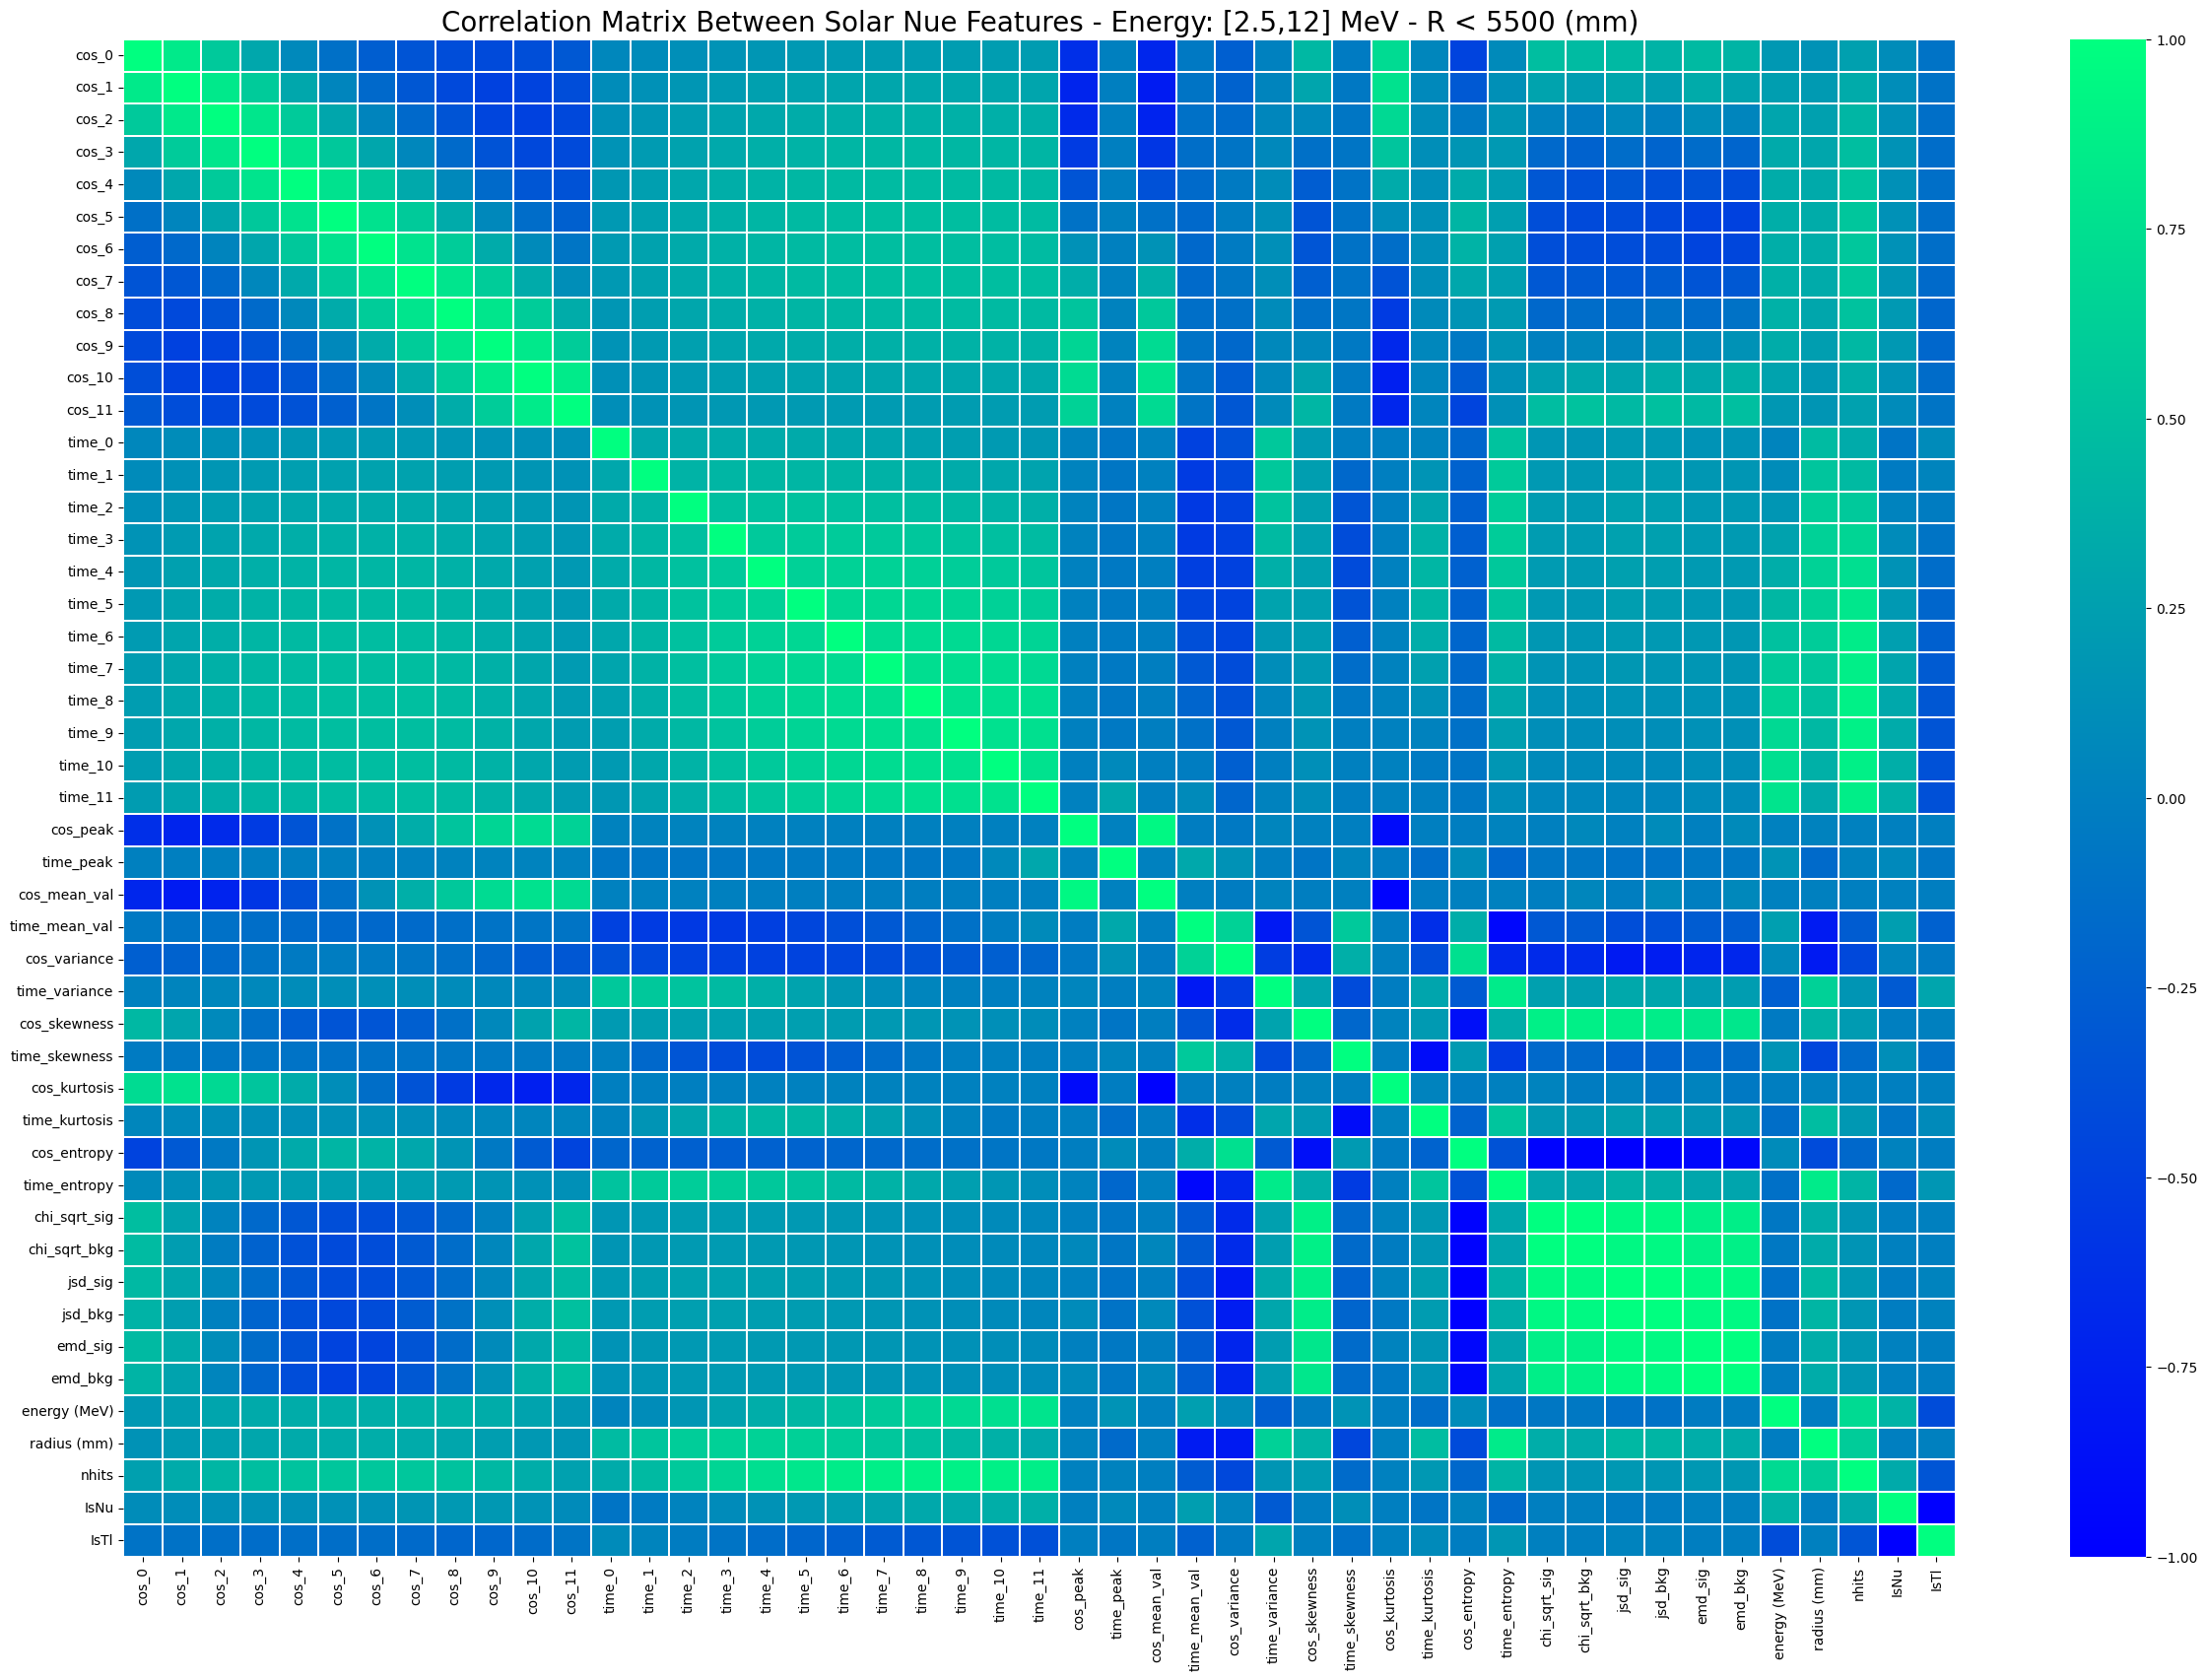

In [55]:
plt.figure(figsize = (30,20))
sn.heatmap(df.corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 20)

Text(0.5, 1.0, 'Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)')

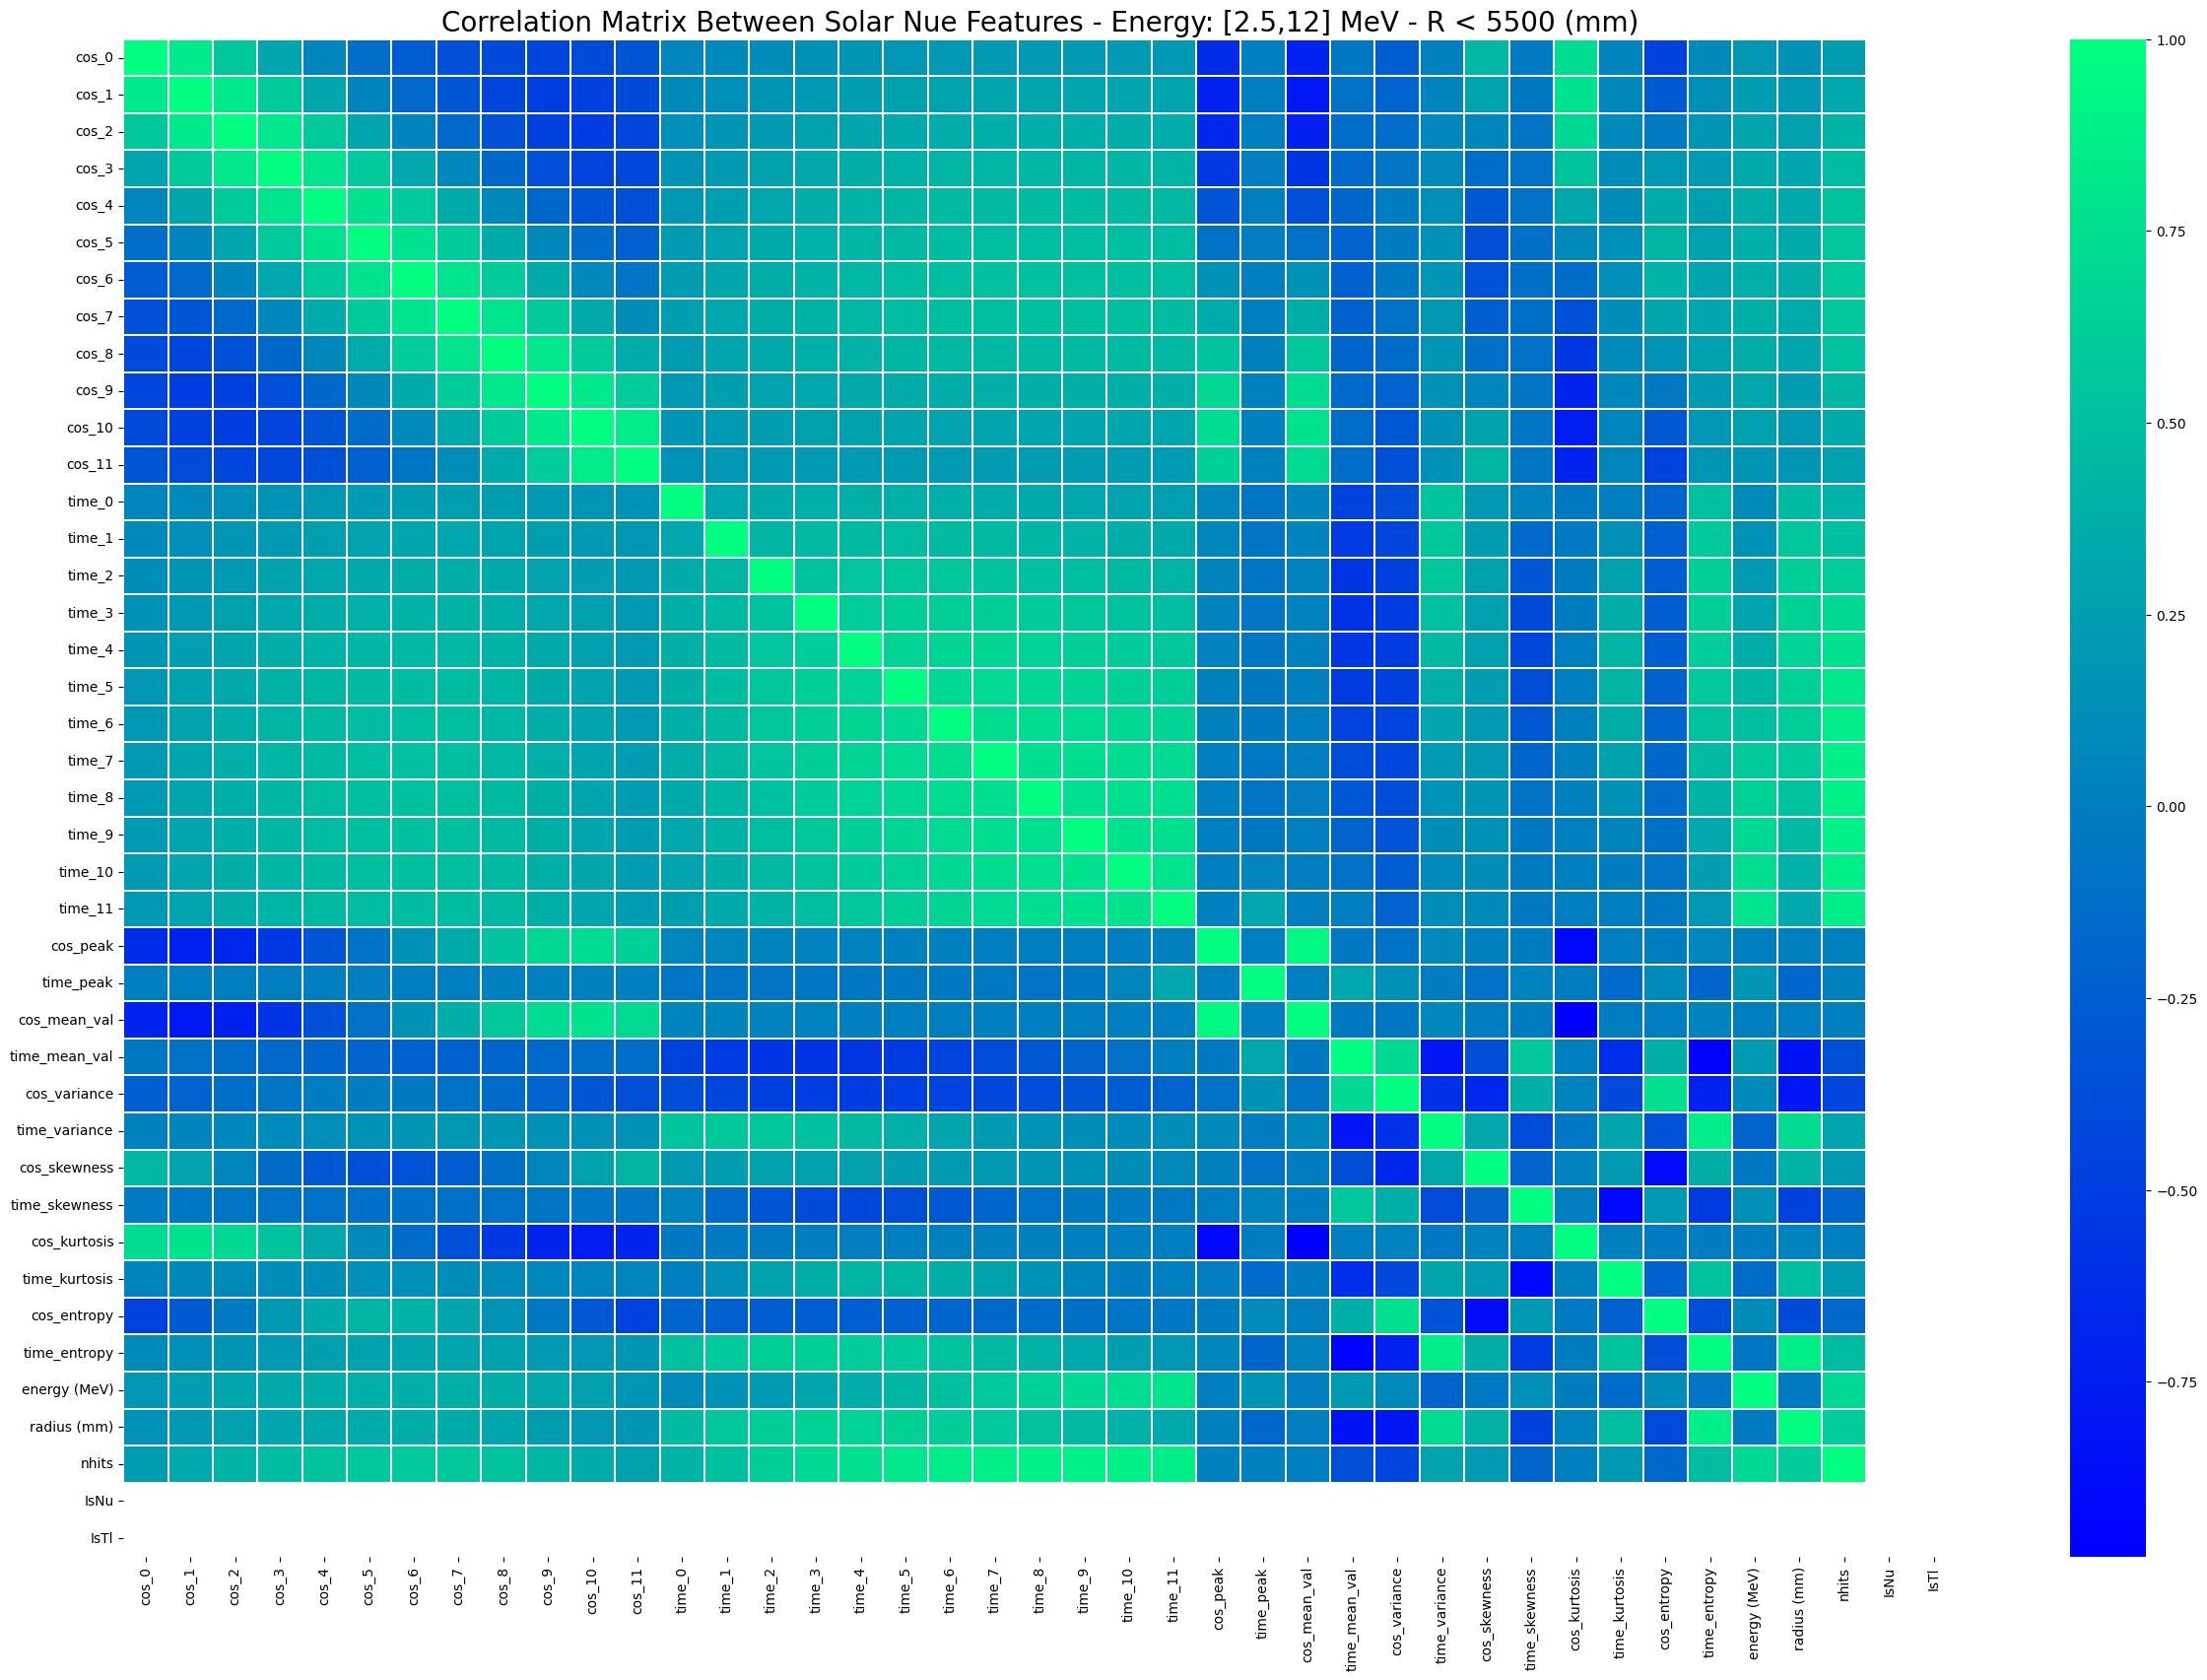

In [51]:
plt.figure(figsize = (30,20))
sn.heatmap(df[df['IsNu'] == 1].corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 20)

Text(0.5, 1.0, 'Correlation Matrix Between 208-Tl Features - Energy: [2.5, 12] MeV - R < 5500 (mm)')

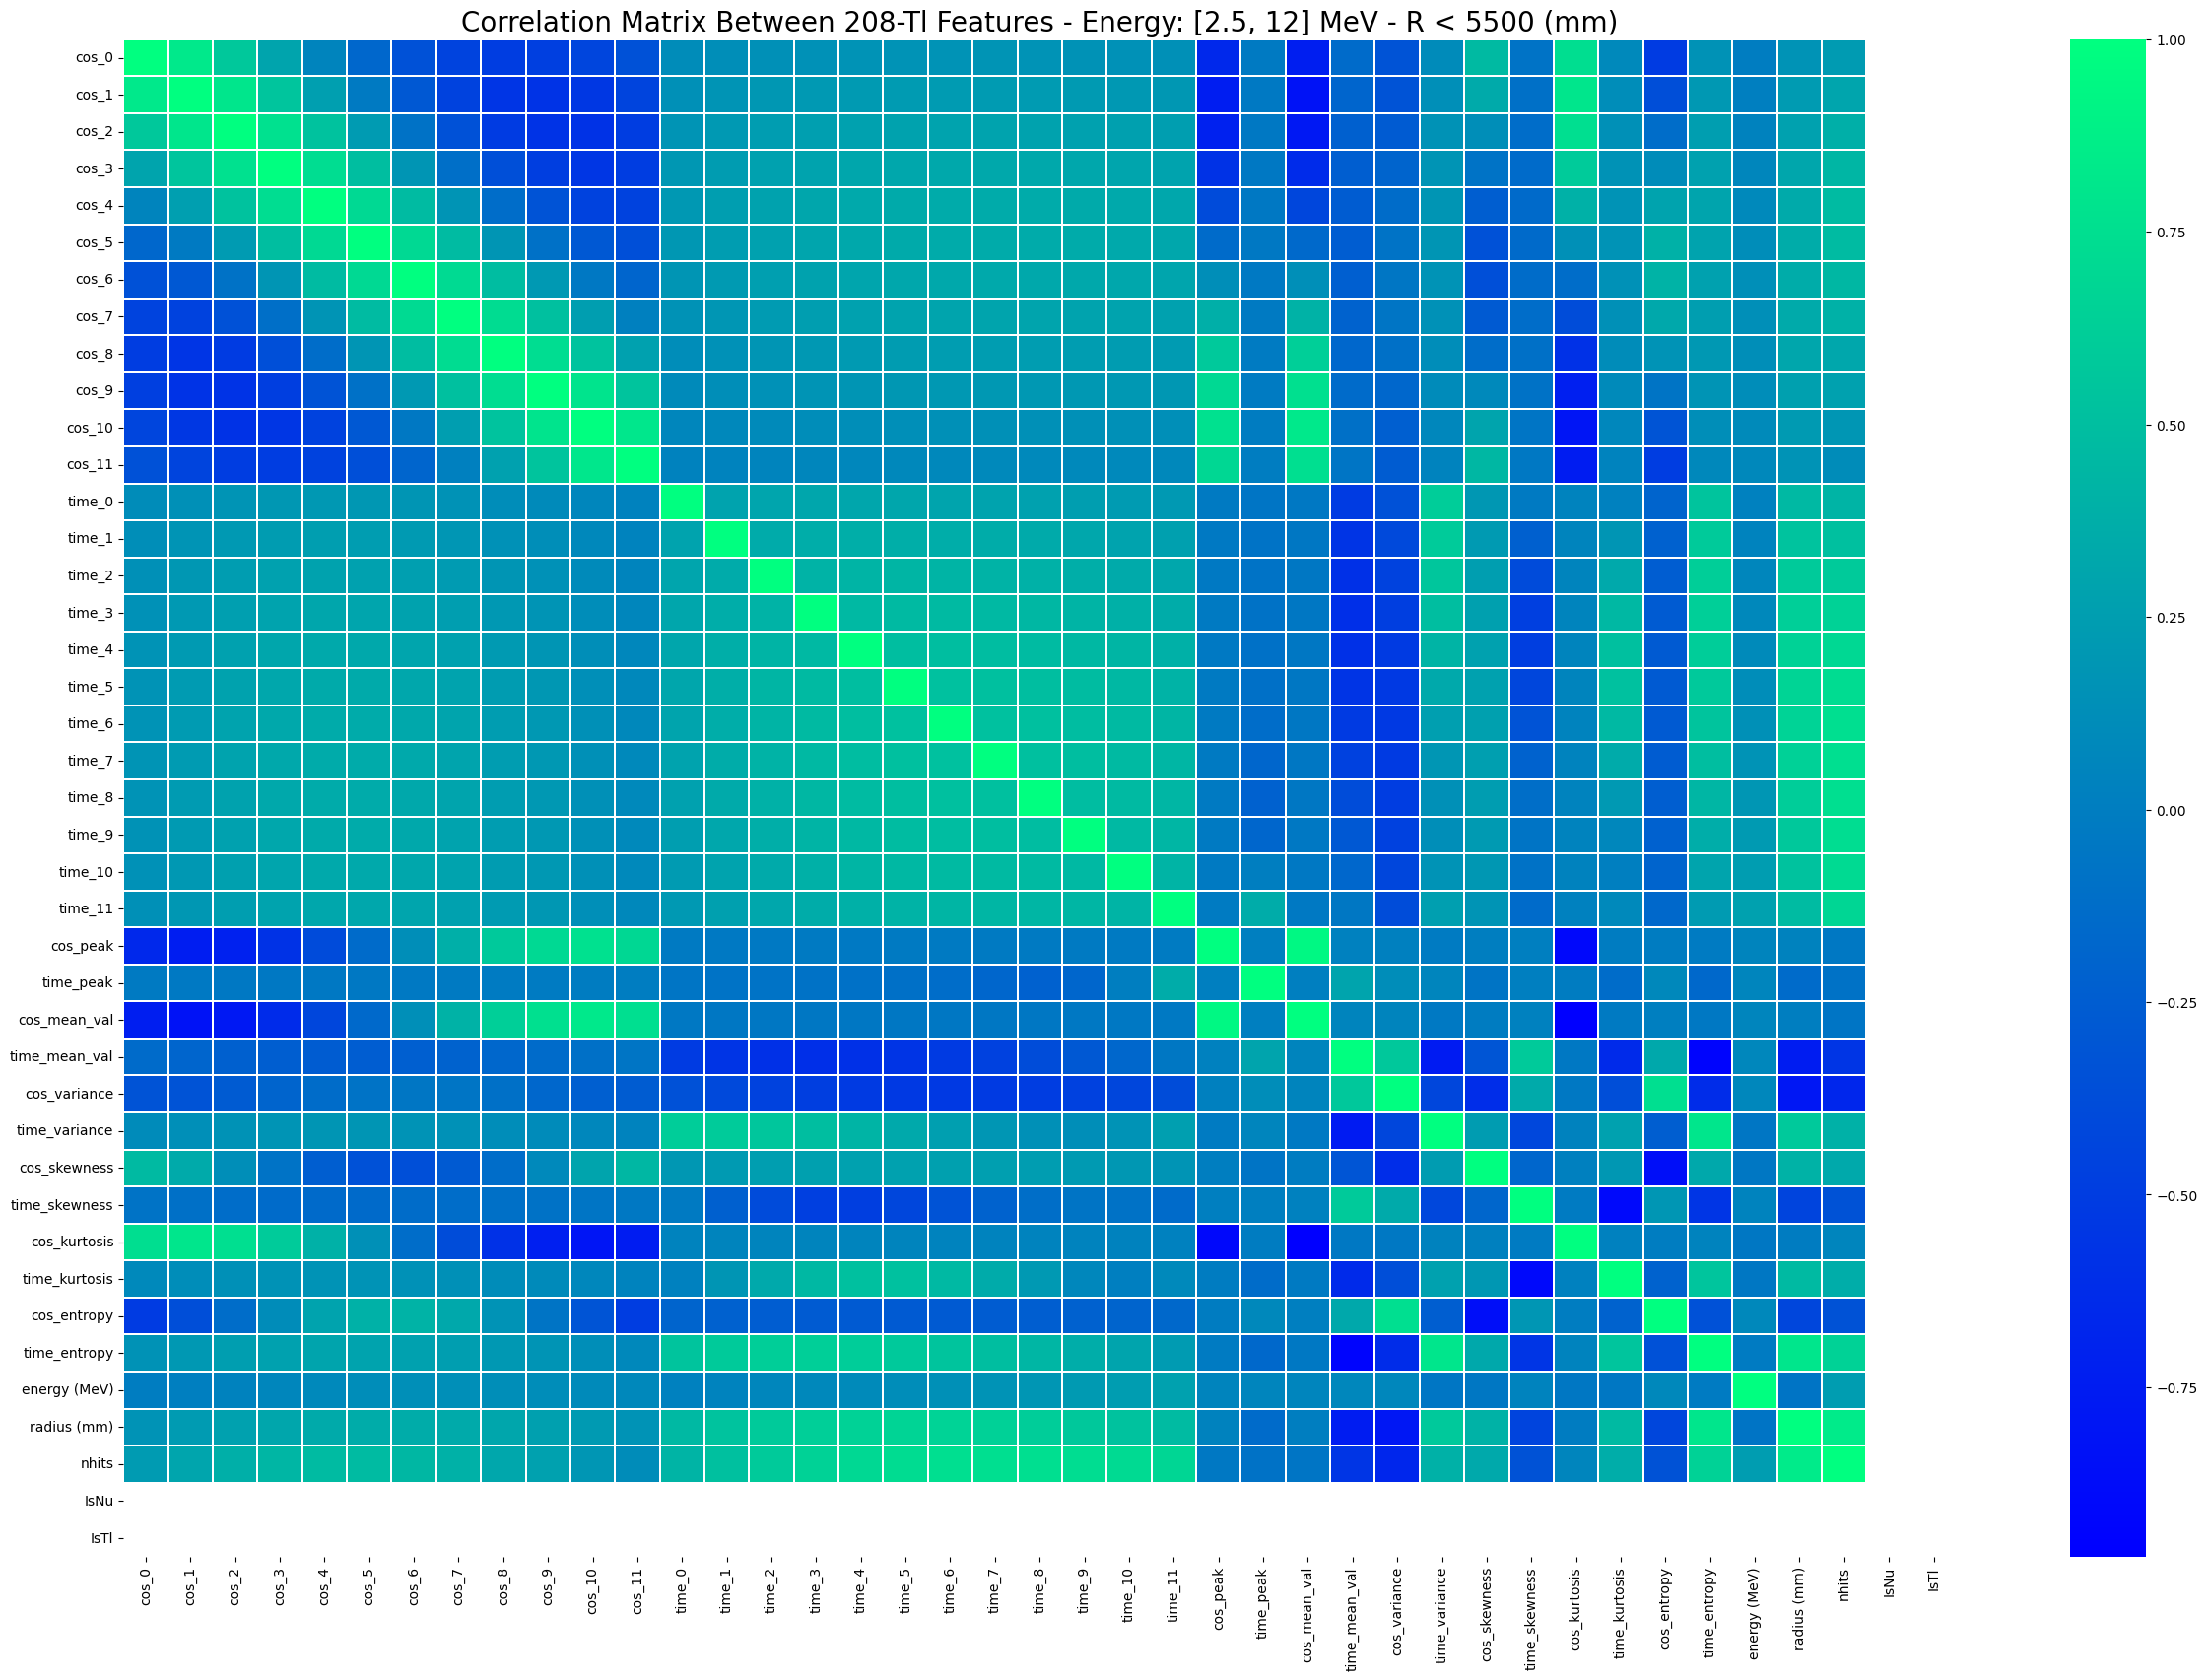

In [52]:
plt.figure(figsize = (30,20))
sn.heatmap(df[df['IsTl'] == 1].corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between 208-Tl Features - Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 20)